<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [6]:
taxi_jan_2019 = pd.read_parquet('data/yellow_tripdata_2019-01.parquet')
taxi_data = pd.concat([taxi_jan_2019])

In [7]:
print(taxi_data.shape)
taxi_data.head()

(7696617, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [8]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [14]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount']]

In [15]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


Plot data into a histogram, data by column

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

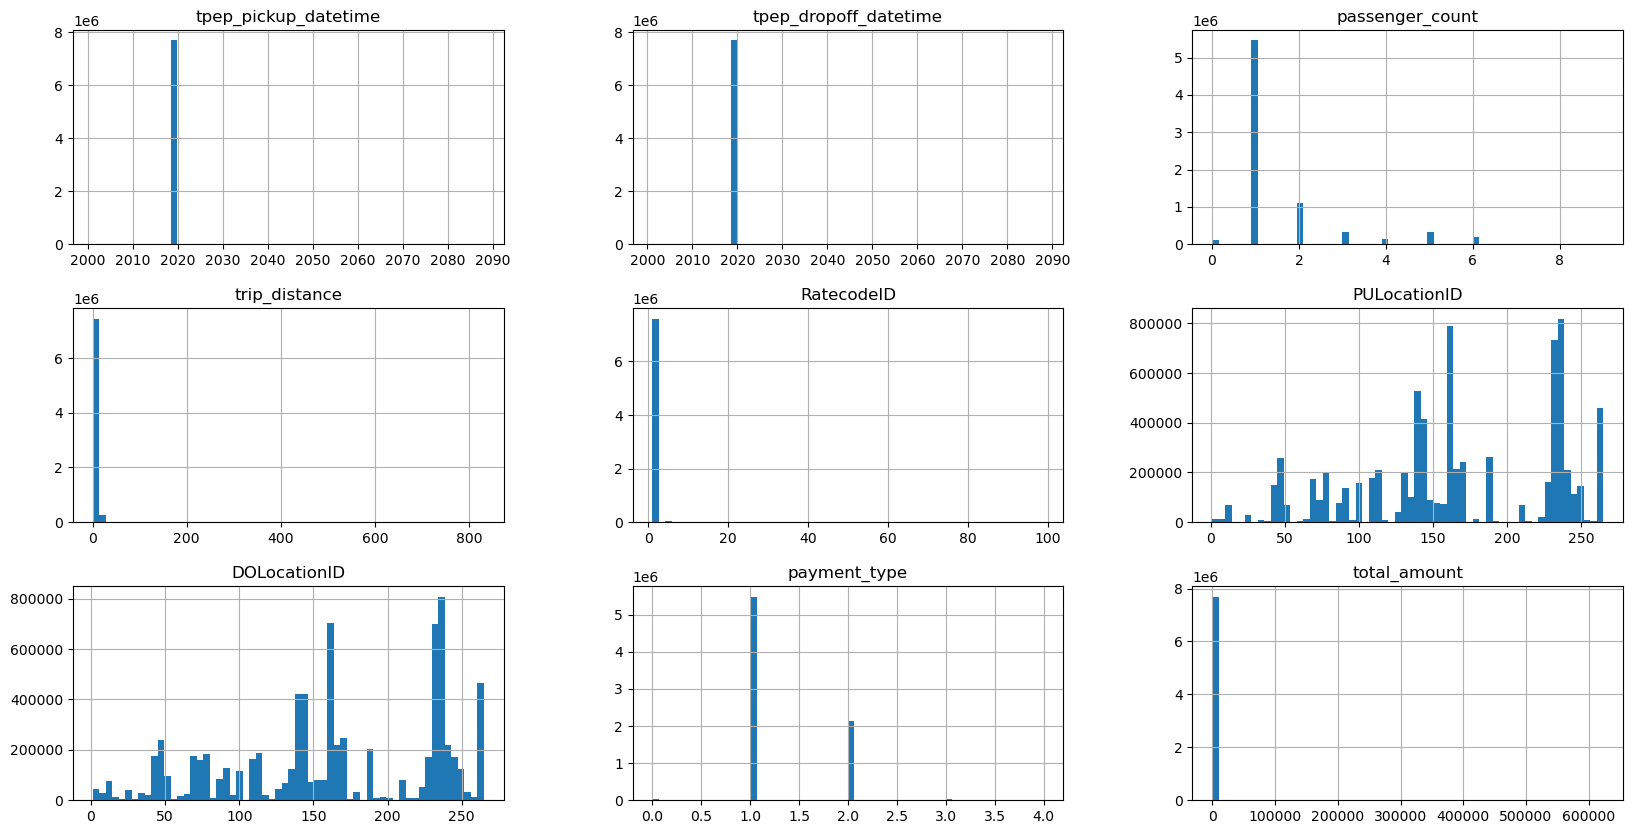

In [16]:
taxi_data.hist(figsize=(20,10), bins=60)

There are some outliers for RatecodeID. An outlier is a data point that differs significantly from other observations.

In [17]:
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     7430288
2.0      166093
5.0       54570
3.0       11801
4.0        4895
99.0        252
6.0          46
Name: count, dtype: int64

After reviewing the data, the values look okay for the Rate Code IDs in the metadata.

There are some outliers for total_amount. Plot all the data from total_amount

<Axes: xlabel='index', ylabel='total_amount'>

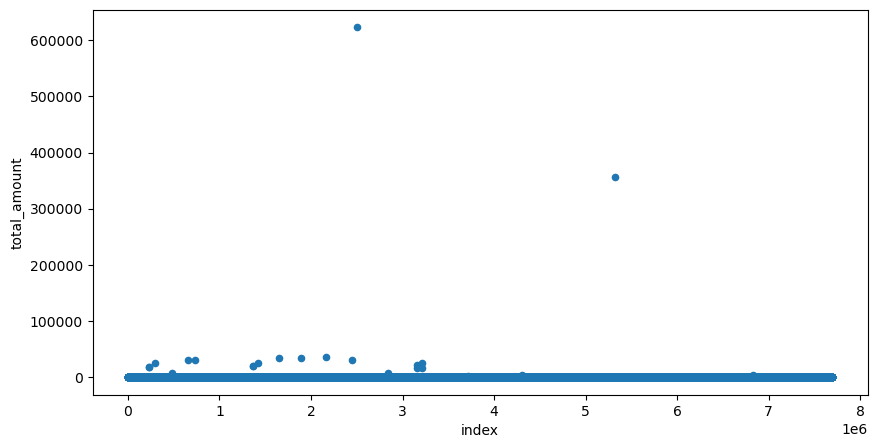

In [19]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

Filter out the outliers values above a 100000

<Axes: xlabel='index', ylabel='total_amount'>

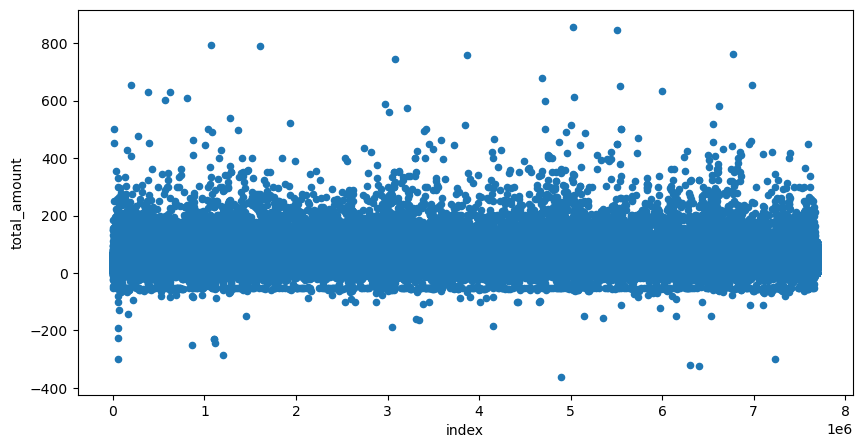

In [20]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

Two things to deal with: negative valuesand very high values. Let's first look at negative values.